# Introduction

In this Data Science project, our goal is to develop a predictive model to estimate a data jobs position's salary based on various characteristics such as State, Rating of the company, important skills and seniority. Using regression techniques, we will see how those variables influences compensation. The project involves exploratory data analysis, the construction of different regression models, and the evaluation of their performance, aiming to create an accurate tool for predicting salaries in various contexts.

# Data Load

In [3]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 36.6 MB/s eta 0:00:00


In [74]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score
)

In [75]:
URL = (
    'https://raw.githubusercontent.com/Andre647/Salary-Prediction/main/data/salary_data_cleaned.csv'
)
salary = pd.read_csv(URL, na_values=-1)
salary.shape

(742, 28)

# Data Cleaning

## Missing Values

In [76]:
salary.isna().sum().sum()

595

In [77]:
# Fill NA values or drop rows with NA in specific columns
salary = (
    salary
    .assign(
        Competitors=salary['Competitors'].fillna(0),
        Rating=salary['Rating'].fillna(salary['Rating'].mean()),
        Industry=salary['Industry'].fillna('Unknown'),
        Sector=salary['Sector'].fillna('Unknown'),
        age=salary['age'].fillna(salary['age'].mean()),
        Founded=salary['Founded'].fillna(salary['Founded'].mean())
    )
    .reset_index(drop=True)
)

salary.dropna(
    subset=['Revenue', 'Type of ownership', 'Size', 'Headquarters'],
    inplace=True
)

In [78]:
salary.isna().sum().sum()

0

## Modifying Columns

In [79]:
# Getting seniority out of Job Title
def seniority(title):
    title = title.lower()

    if any(keyword in title for keyword in
           ['sr', 'senior', 'lead', 'principal', 'manager', 'ii', 'iii']):
        return 'senior'
    elif any(keyword in title for keyword in
             ['iv', 'vp', 'director', 'chief']):
        return 'director'
    elif any(keyword in title for keyword in
             ['jr', 'i', 'junior']):
        return 'jr'
    else:
        return 'na'

salary['seniority'] = salary['Job Title'].apply(seniority)

In [80]:
salary['seniority'].value_counts()

,count
seniority,
jr,434
senior,259
na,28
director,20


In [81]:
# Simplifying job titles
def title_simplifier(title):
    title = title.lower()

    if 'data scientist' in title:
        return 'data scientist'
    elif 'data engineer' in title:
        return 'data engineer'
    elif 'analyst' in title:
        return 'analyst'
    elif 'machine learning' in title:
        return 'mle'
    elif 'manager' in title:
        return 'manager'
    elif 'director' in title:
        return 'director'
    else:
        return 'na'

salary['Job Simp'] = salary['Job Title'].apply(title_simplifier)

In [82]:
salary['Job Simp'].value_counts()

,count
Job Simp,
data scientist,279
na,183
data engineer,119
analyst,102
manager,22
mle,22
director,14


In [83]:
salary.rename(
    columns={
        'avg_salary': 'Salary',
        'company_txt': 'Company',
        'python_yn': 'python',
        'R_yn': 'R',
        'Job Simp': 'Job Title'
    },
    inplace=True
)

In [84]:
# Cleaning categorical variables for our model
salary = (
    salary
    .assign(
        Company=salary['Company'].apply(lambda x: x.split('\n')[0]),
        NCompetitors=salary['Competitors'].apply(
            lambda x: len(x.split(',')) if isinstance(x, str) else x
        ),
        Salary=salary.apply(
            lambda x: x['Salary'] * 2 if x['hourly'] == 1 else x['Salary'],
            axis=1
        )
    )
)

In [85]:
# Dropping the columns we are not using
salary.drop(
    columns=[
        'Job Title',
        'Location',
        'Headquarters',
        'Industry',
        'Competitors',
        'hourly',
        'max_salary',
        'min_salary',
        'employer_provided',
        'Company Name',
        'Job Description',
        'Salary Estimate',
        'Founded'
    ],
    inplace=True
)

In [86]:
# Changing column order for a cleaner view
new_order = [
    'Company',
    'seniority',
    'Size',
    'Type of ownership',
    'Sector',
    'Revenue',
    'NCompetitors',
    'Rating',
    'job_state',
    'age',
    'python',
    'R',
    'spark',
    'aws',
    'excel',
    'Salary'
]

salary = salary[new_order]

In [87]:
salary.shape

(741, 16)

# EDA

                                             |          | [  0%]   00:00 -> (? left)


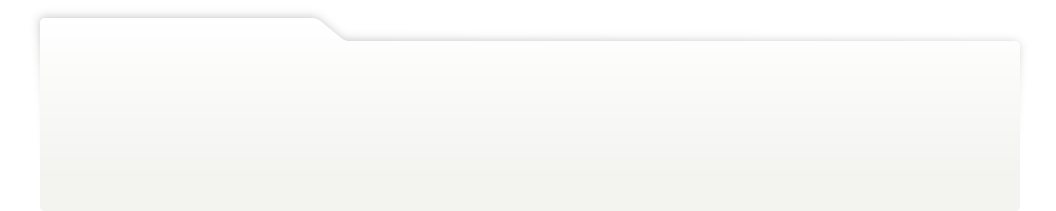
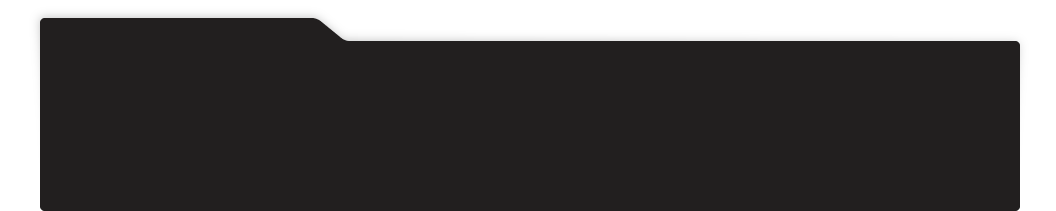
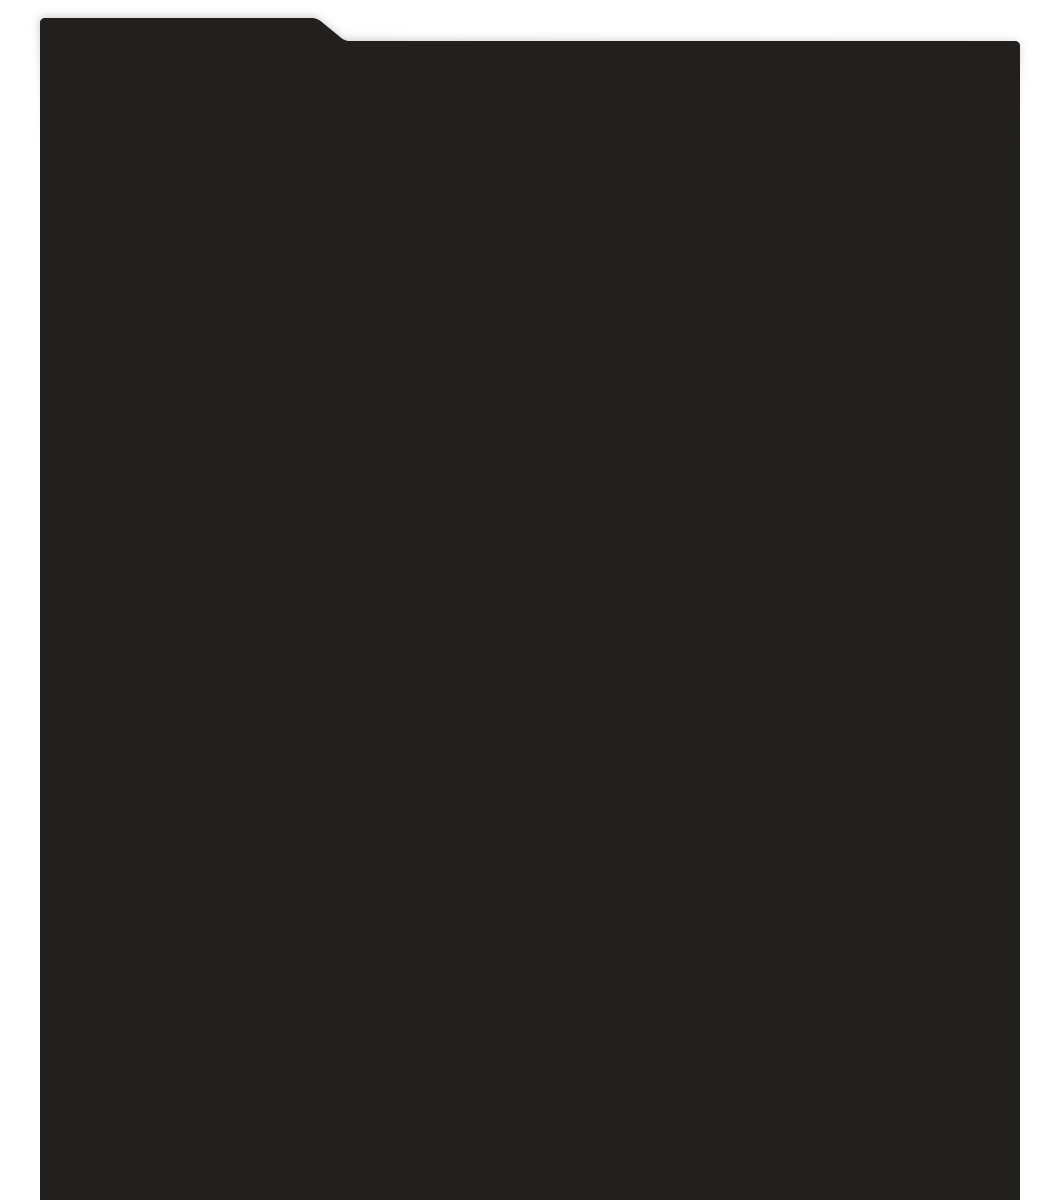
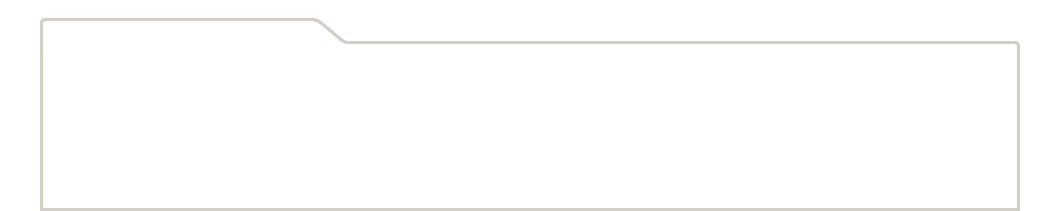
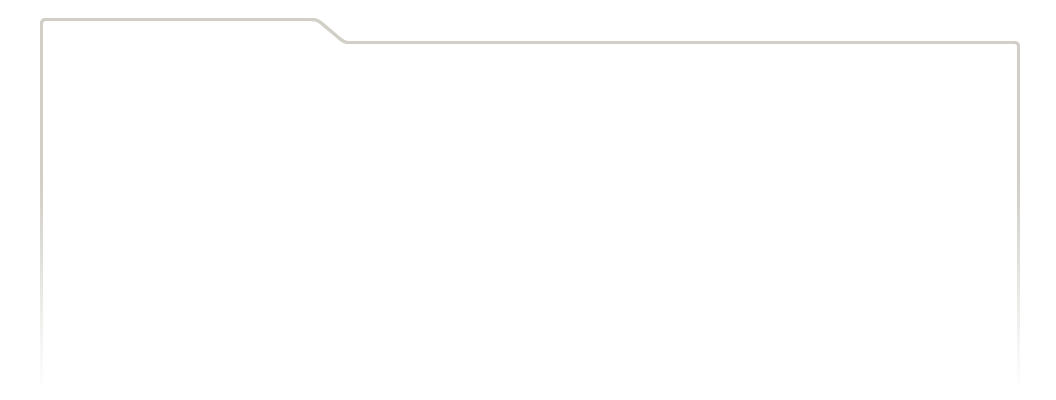
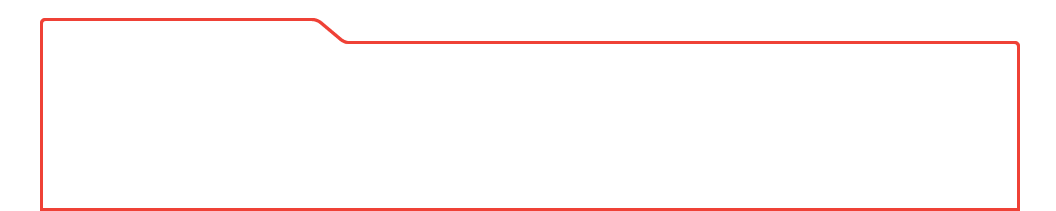
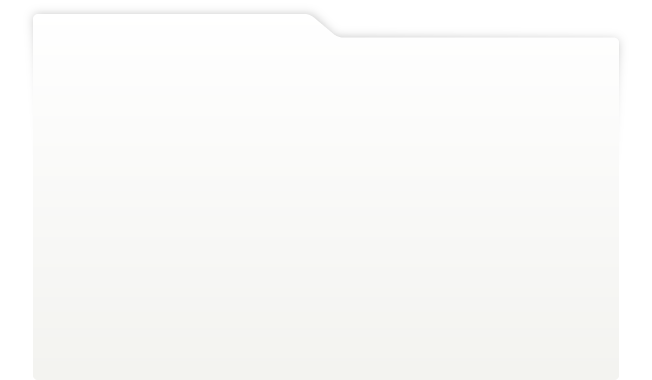
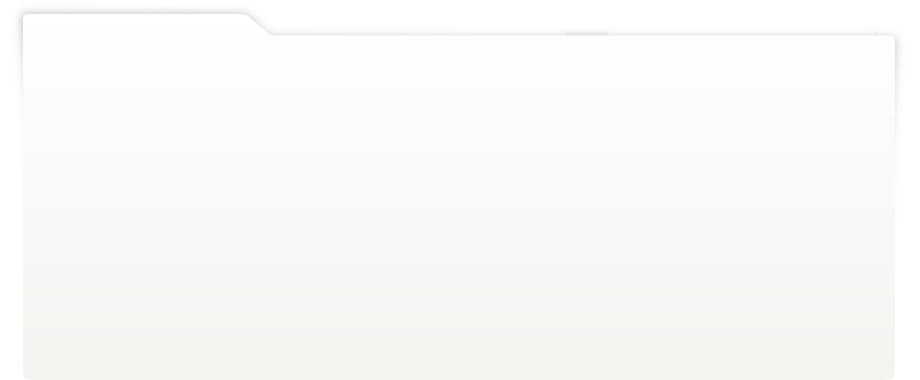
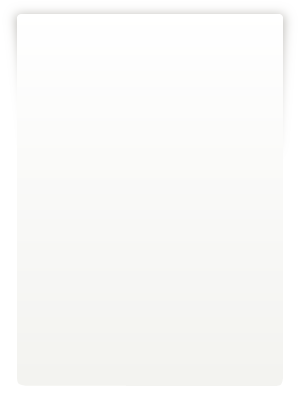
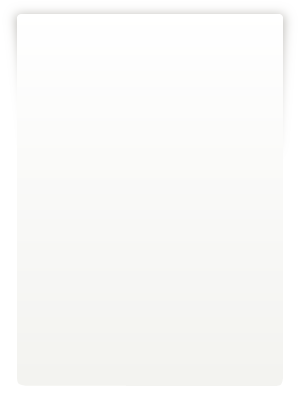
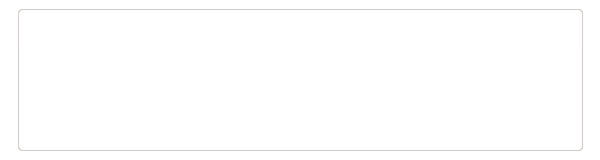
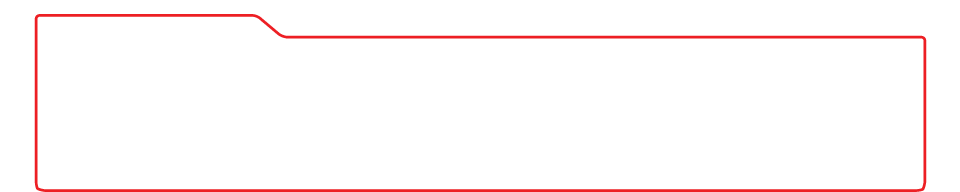
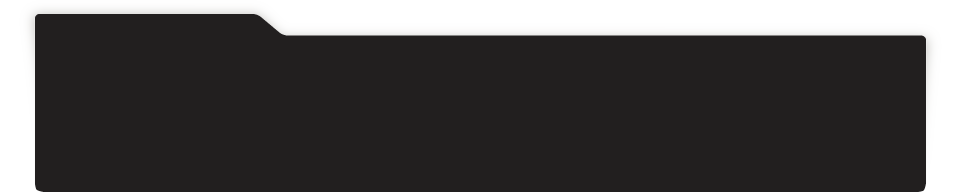
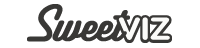
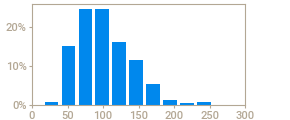
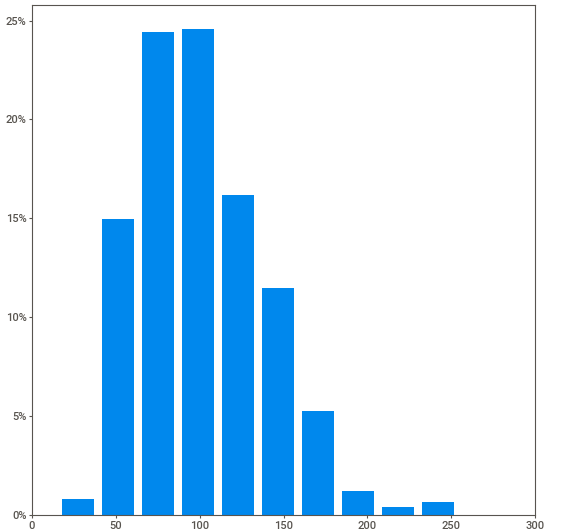
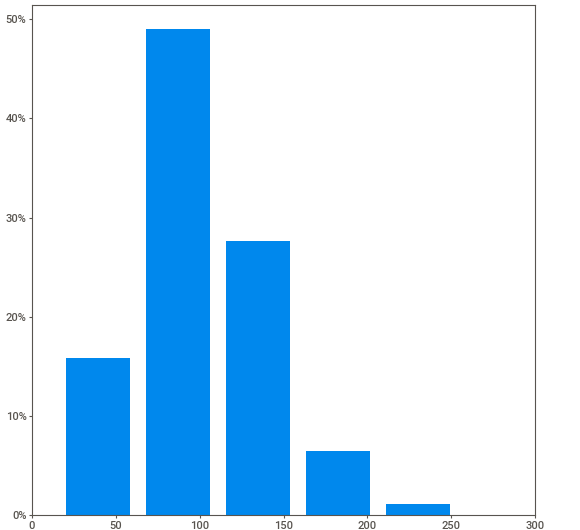
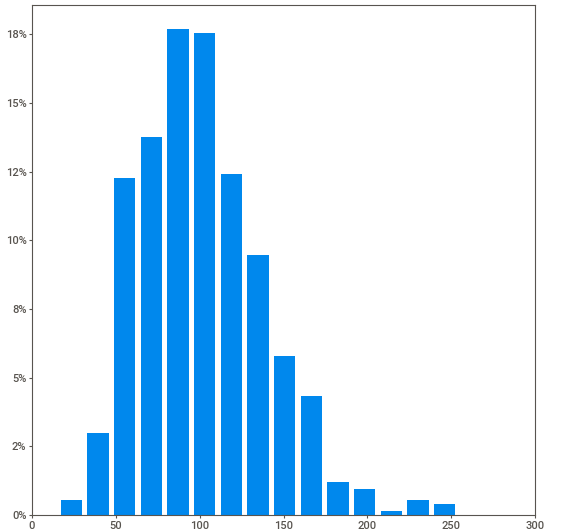
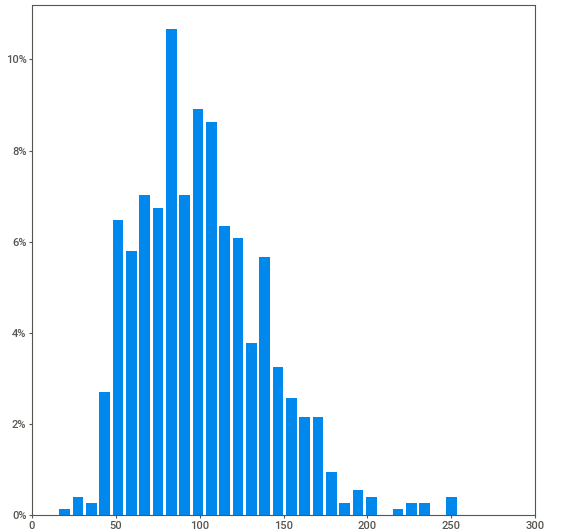
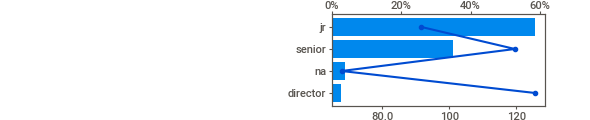
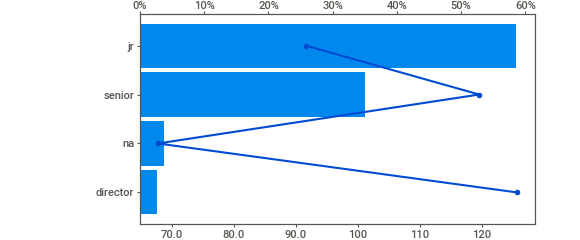
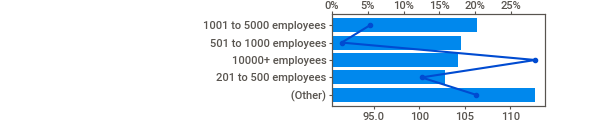
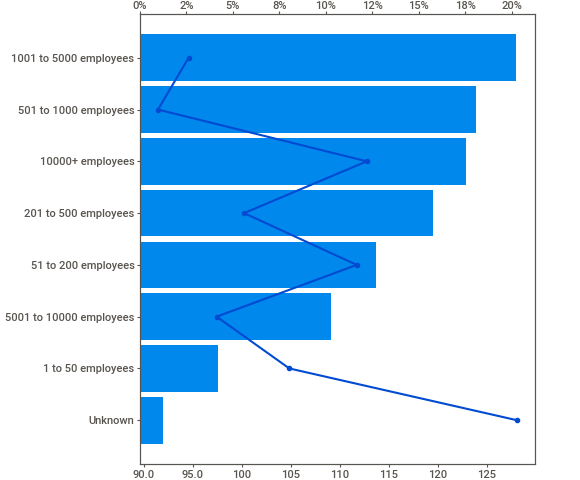
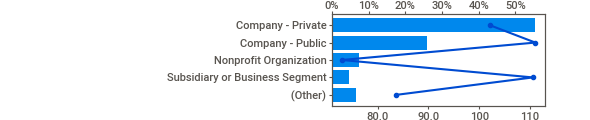
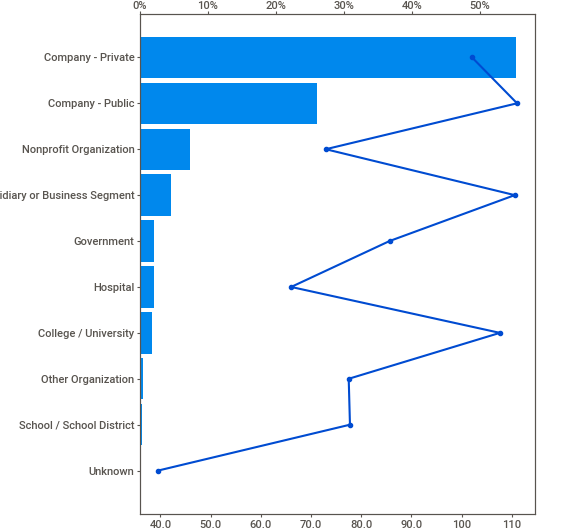
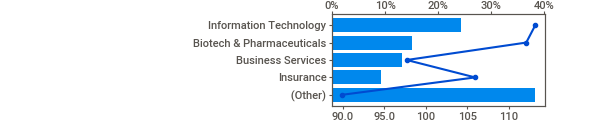
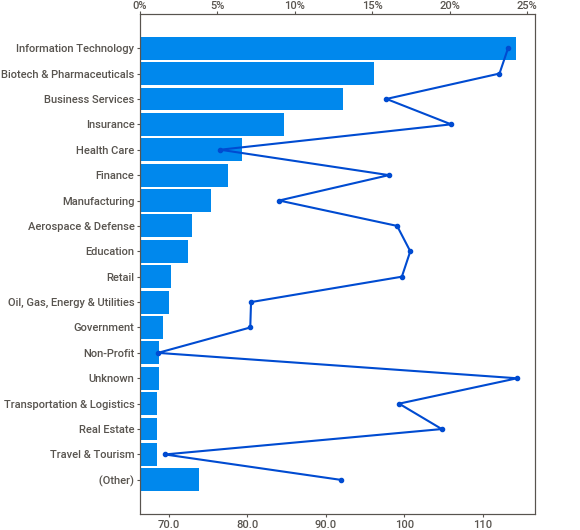
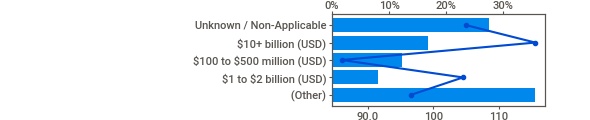
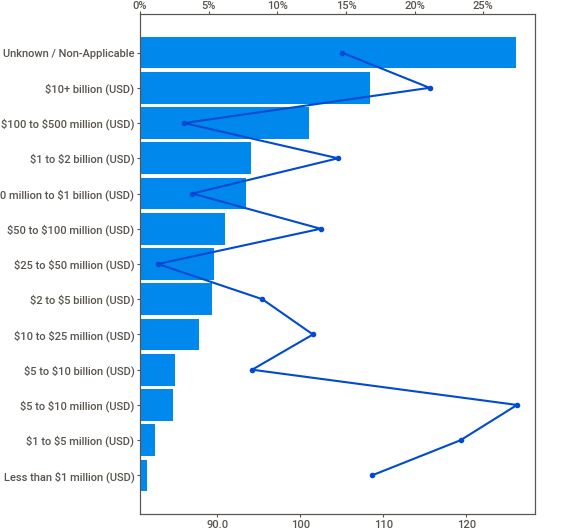
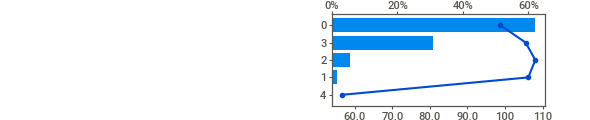
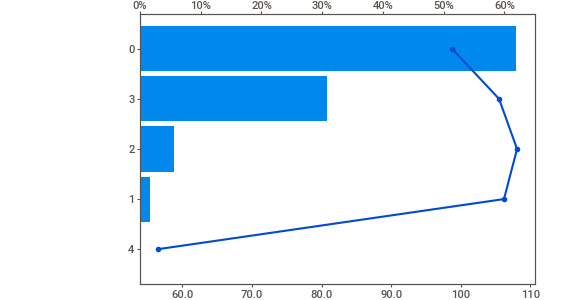
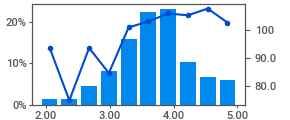
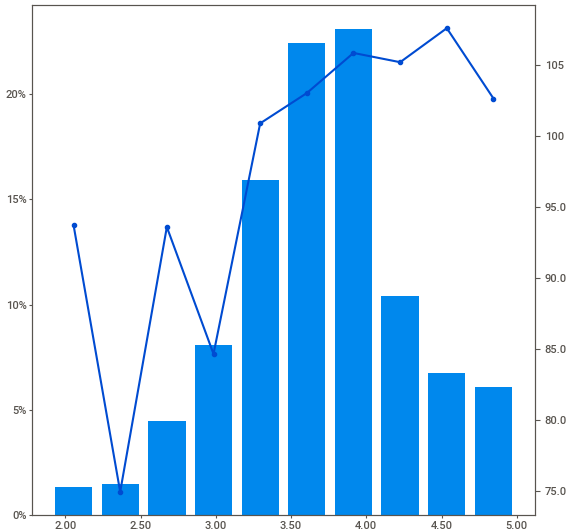
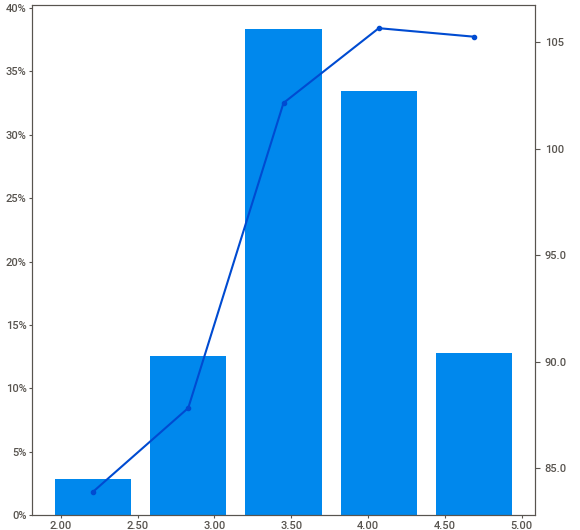
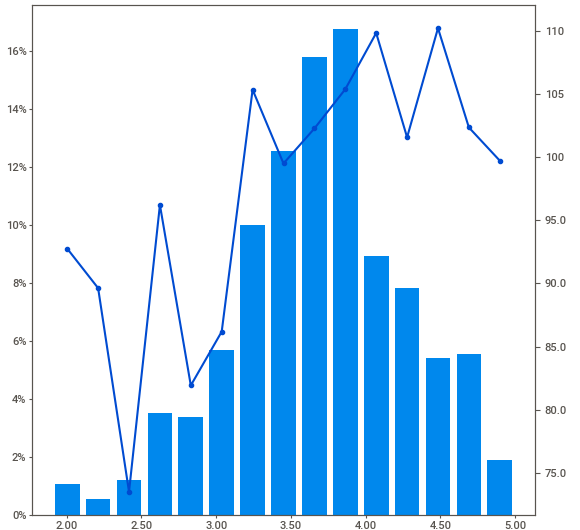
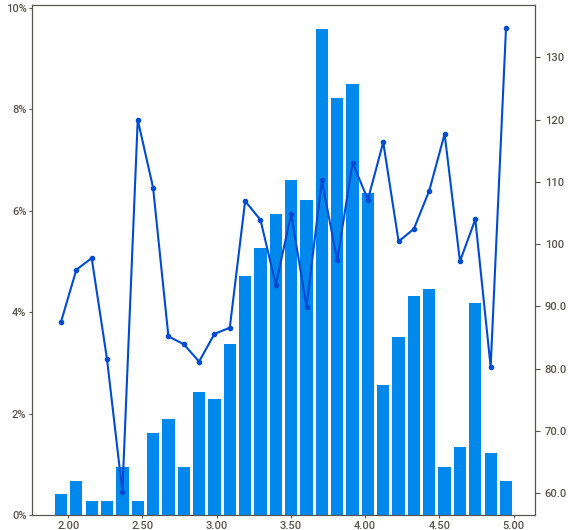
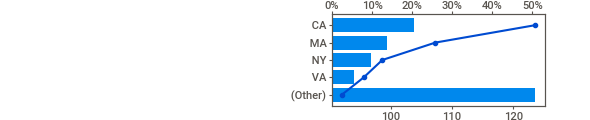
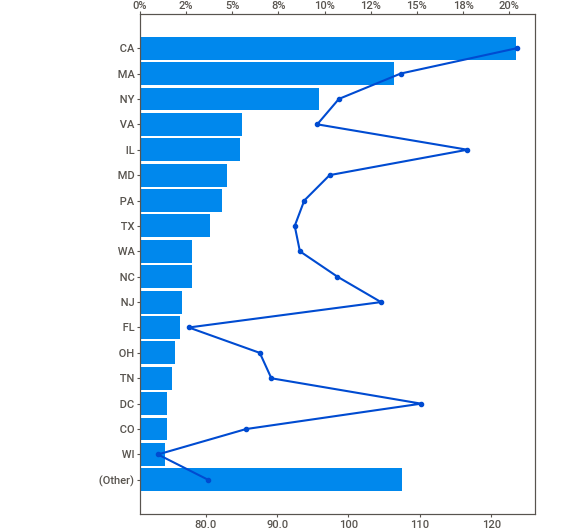
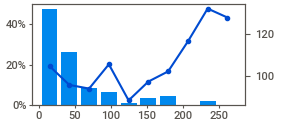
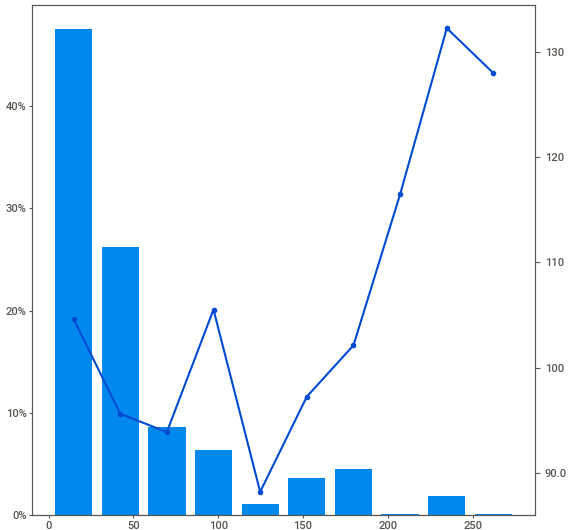
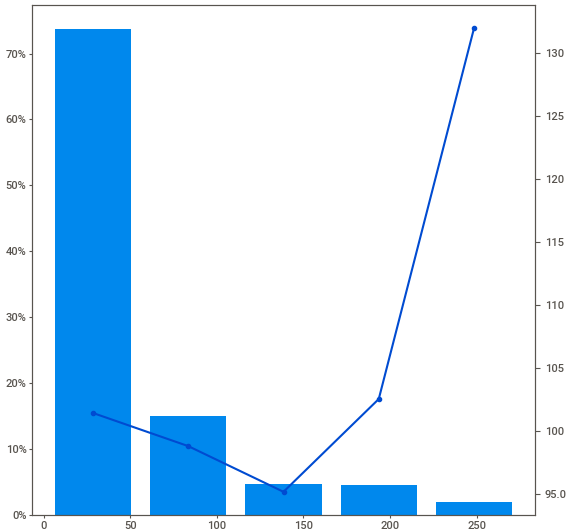
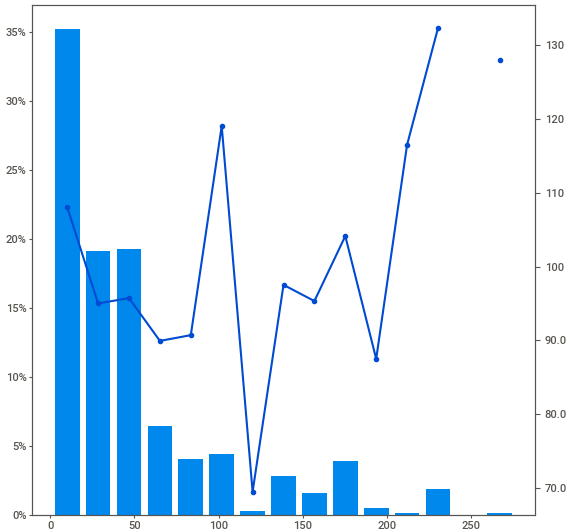
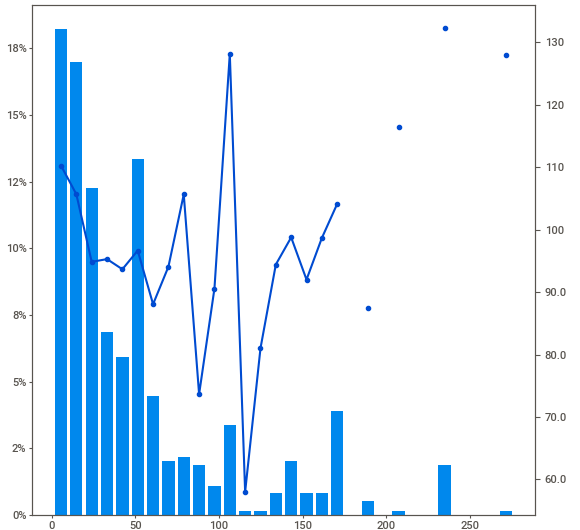
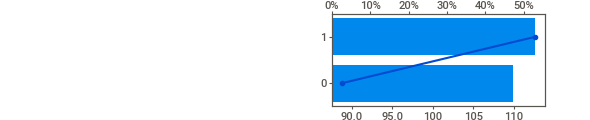
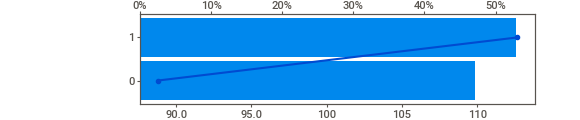
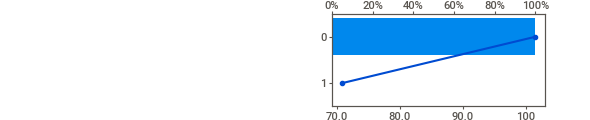
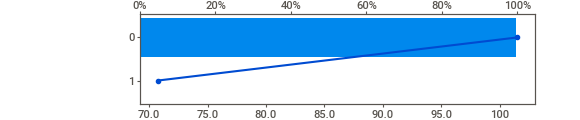
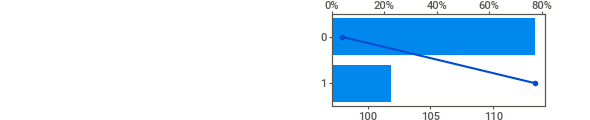
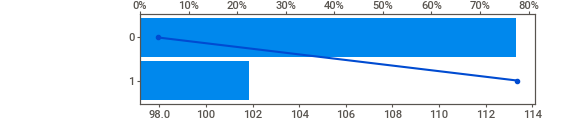
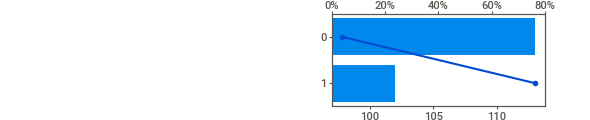
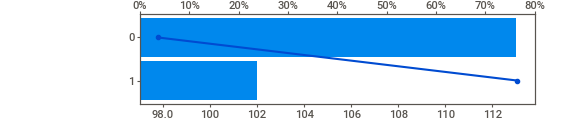
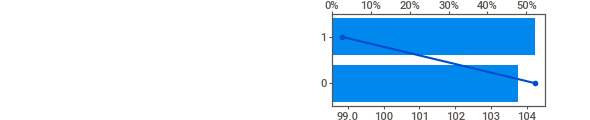
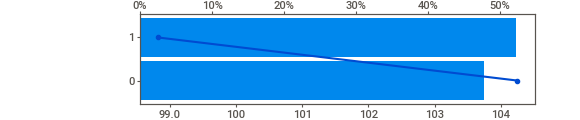
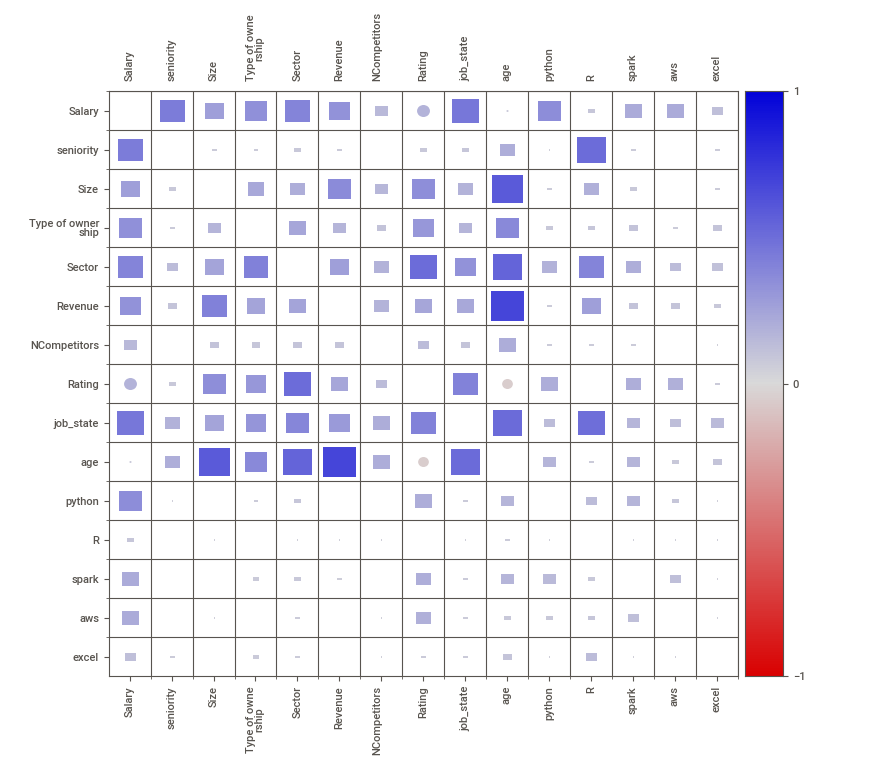
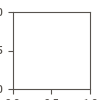

In [88]:
my_report = sv.analyze(salary, target_feat='Salary')
my_report.show_notebook(layout='vertical')

In [89]:
sns.set_palette(palette='viridis', n_colors=1)

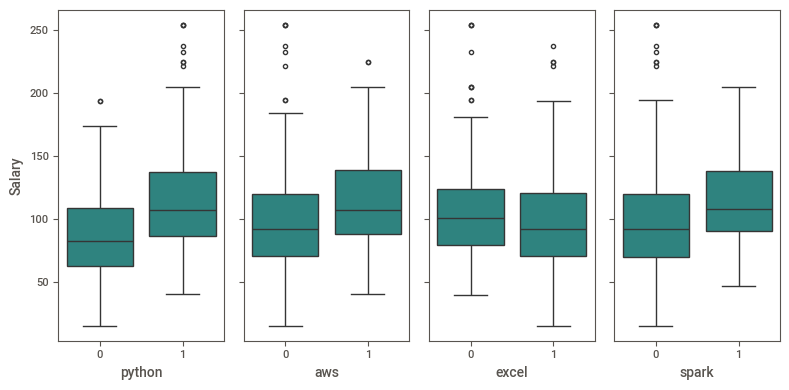

In [90]:
fig, axes = plt.subplots(1, 4, figsize=(8, 4), sharey=True)

[ sns.boxplot(x=coluna, y='Salary', data=salary, ax=ax) for ax, coluna in zip(axes.flatten(), ['python', 'aws', 'excel', 'spark']) ]

plt.tight_layout()
plt.show()

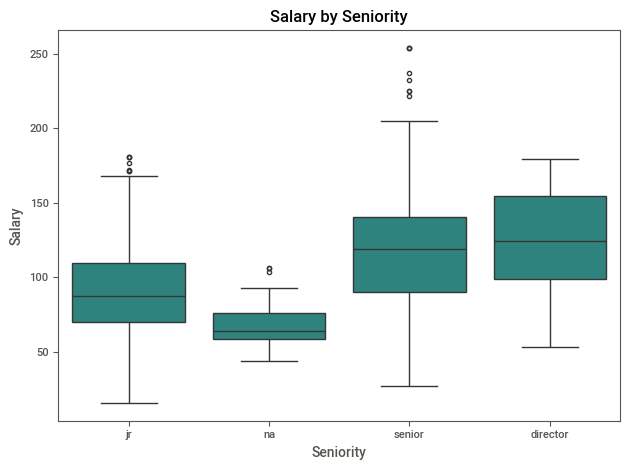

In [91]:
# Create a boxplot of Salary by Seniority
sns.boxplot(x='seniority', y='Salary', data=salary)

plt.title('Salary by Seniority')
plt.xlabel('Seniority')
plt.ylabel('Salary')

plt.tight_layout()
plt.show()

With the SweetVis report, it is possible to visualize the distribution of all our variables and how our target variable "Salary" varies for each of them. Additionally, the report provides the correlation map between our variables, showing us which ones are most important for the problem, effectively performing almost all of our exploratory data analysis. Above, two of our most relevant graphs are plotted.

  * It is possible to see that, as expected, the **seniority** of the position has a significant impact on the salary it offers. However, more than half of our data does not have this defined. Standardizing seniority for each position on Glassdoor would help us address this issue.

  * Digging deeper, we can also see that positions place more value on individuals with expertise in **Python, AWS, and even Spark**, which was anticipated, given that our positions are mostly in the Data field. We can also observe that Excel is becoming undervalued in the market.

  * The report also provides other relevant information, such as **California** being one of the highest-paying states and that companies with **higher ratings** also tend to offer **higher salaries**.

# Modeling

In [92]:
salary.shape

(741, 16)

In [93]:
df = salary.drop(columns=['Company','R','excel','age'])
df.shape

(741, 12)

## Outliers

In [94]:
from scipy import stats

z_scores = np.abs(stats.zscore(df.select_dtypes('number')))
limit = 4.0

df= df[(z_scores < limit).all(axis=1)]
df.shape

(738, 12)

## Hot-Encode

In [95]:
from sklearn.preprocessing import OneHotEncoder

hot_encode = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False,
    drop='first'
)

categorical_features = df.select_dtypes(exclude='number')
hot_encode.fit(categorical_features)

df_hot = pd.DataFrame(
    hot_encode.transform(categorical_features),
    columns=hot_encode.get_feature_names_out()
)

df = df_hot.join(df.select_dtypes(include='number'))

df = df.dropna()
df.head()

,seniority_jr,seniority_na,seniority_senior,Size_10000+ employees,Size_1001 to 5000 employees,Size_201 to 500 employees,Size_5001 to 10000 employees,Size_501 to 1000 employees,Size_51 to 200 employees,Size_Unknown,...,job_state_ UT,job_state_ VA,job_state_ WA,job_state_ WI,NCompetitors,Rating,python,spark,aws,Salary
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.8,1.0,0.0,0.0,72.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.4,1.0,0.0,0.0,87.5
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.8,1.0,1.0,0.0,85.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,3.0,3.8,1.0,0.0,0.0,76.5
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.9,1.0,0.0,0.0,114.5


In [96]:
X = df.drop(columns=['Salary'])
y = df['Salary']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

## Linear Regression

In [98]:
lm = LinearRegression().fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [99]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lm, X_test, y_test, cv=3, scoring='r2')
print(f'R-quadrado médio com validação cruzada: {np.mean(scores)}')

R-quadrado médio com validação cruzada: -2.3931046045787376e+26


## Lasso Regression

In [100]:
lasso = Lasso(alpha=0.1).fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [101]:
scores = cross_val_score(lasso, X_test, y_test, cv=3, scoring='r2')
print(f'r-quadrado médio com validação cruzada: {np.mean(scores)}')

r-quadrado médio com validação cruzada: -0.5797780961532699


## Random Forest Regression

In [102]:
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [103]:
scores = cross_val_score(rf, X_test, y_test, cv=3, scoring='r2')
print(f'r-quadrado médio com validação cruzada: {np.mean(scores)}')

r-quadrado médio com validação cruzada: 0.2085313842354738


We will use the **Random Forest model** since it appears to provide the best **R-squared**, in addition to having the advantage of being insensitive to **normalization**.

## Grid Search

In [104]:
parameters = {
    'n_estimators': range(10, 300, 50),
    'criterion': ['friedman_mse', 'absolute_error'],
    'max_features': [None, 'sqrt', 'log2']
}

gs = GridSearchCV(
    estimator=rf,
    param_grid=parameters,
    error_score='raise',
    cv=3
)

gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ('friedman_mse', 'absolute_error'),
                         'max_features': (None, 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 50)})

In [105]:
gs.best_params_

{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 60}

# Results

R-squared is the metric that shows us how much of our data explains our outcome, in this case, the Salary.

In [109]:
from sklearn.metrics import r2_score
y_pred = gs.predict(X_test)

# R²
r2_score(y_test, y_pred)

0.4635129230974169

We will start visualizing the residuals, which helps us identify whether the model is biased or if it is 'randomly making errors,' which is ideal.

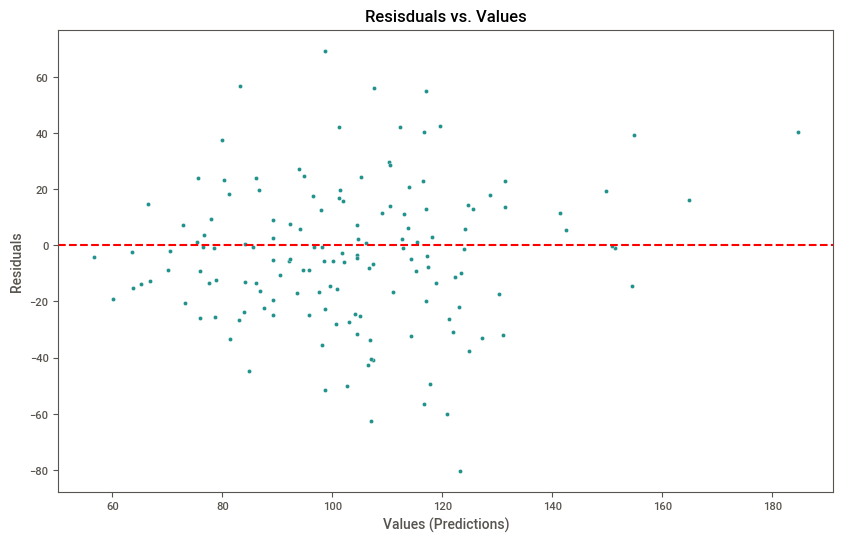

In [107]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Resisduals vs. Values')
plt.show()

Next, we will analyze whether the residuals follow a normal distribution. This is important because the normality of the residuals helps validate the model, ensures confidence in the inferences it provides, and guarantees that there are no significant uncaptured patterns, contributing to the model's robustness and reliability.

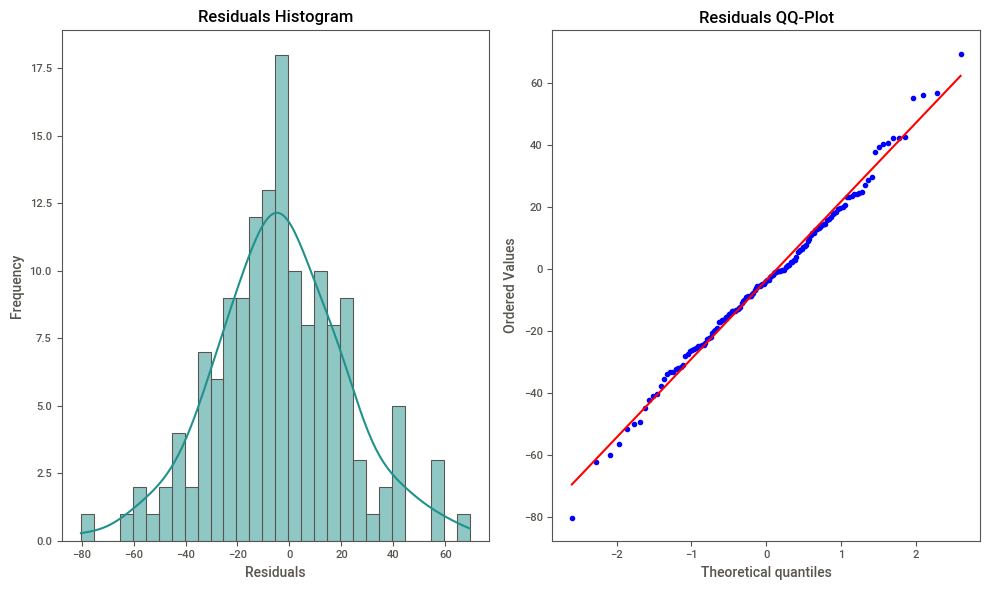

In [110]:
fig, ax= plt.subplots(1,2, figsize=(10, 6))

sns.histplot(residuals, kde=True, bins=30, ax=ax[0])
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Residuals Histogram')

stats.probplot(residuals, dist="norm", plot=ax[1])
plt.title('Residuals QQ-Plot')

plt.tight_layout()
plt.show()

## Conclusion

## R-squared

An R-squared of 0.46 in a regression model indicates that approximately 46% of the variability in the outcome (or dependent variable) is explained by the model. In other words, about 46% of the variation in the data can be attributed to the independent variables included in the model, while the remaining 54% is due to other factors not included in the model or random variations.

* Moderate Explanation: The model explains a moderate amount of the variability in the data. While it is not a perfect model, it provides a significant amount of explanation for the outcome.

* Room for Improvement: An R-squared of 0.47 suggests that there is room to improve the model. It may be useful to explore other variables or adjust the model to enhance the explanation of the variability.

## Residuals
* The Residuals vs. Predicted plot shows that the errors are randomly distributed, indicating that our model does not exhibit any 'bias' or tendency toward a certain value.

* Our histogram of residuals and the QQ-Plot indicate that they are following a normal distribution, validating the results of the model.